In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [4]:
def load_subject(subject, volumes):
    df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [5]:
df_mouse = load_subject(subjects[0], volumes=volumes)

# Analysis on C57 : threshold 300

In [11]:
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject, 
                                                                                                volumes=volumes), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_c57.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_c57.npy', allow_pickle=True).item()

# List areas with null cell count

In [14]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

<AxesSubplot:>

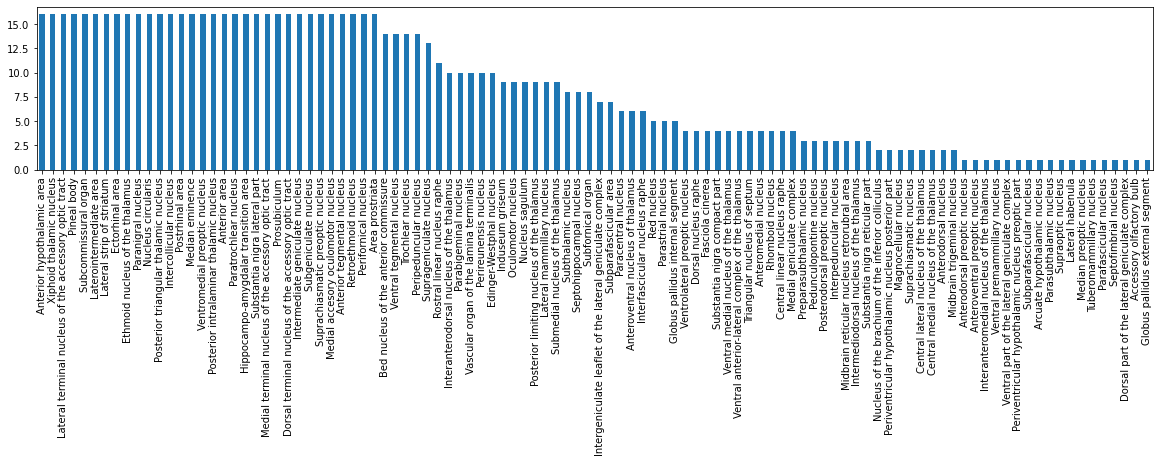

In [15]:
# make histogram of these
null_areas = [db_null_count[subjects[0]].area.values]
for subject in subjects[1:]:
    null_areas.append(db_null_count[subject].area.values)
null_areas = np.hstack(null_areas)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_areas).value_counts(sort=True).plot(kind='bar', axes=ax)


In [16]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_areas).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string(), len(df))

                                                       counts
Anterior hypothalamic area                                 16
Medial terminal nucleus of the accessory optic tract       16
Prosubiculum                                               16
Dorsal terminal nucleus of the accessory optic tract       16
Intermediate geniculate nucleus                            16
Subgeniculate nucleus                                      16
Hippocampo-amygdalar transition area                       16
Anterior tegmental nucleus                                 16
Perifornical nucleus                                       16
Suprachiasmatic preoptic nucleus                           16
Lateral terminal nucleus of the accessory optic tract      16
Anterior area                                              16
Subcommissural organ                                       16
Lateral strip of striatum                                  16
Ectorhinal area                                            16
Xiphoid 

# List areas with no volume

In [17]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

<AxesSubplot:>

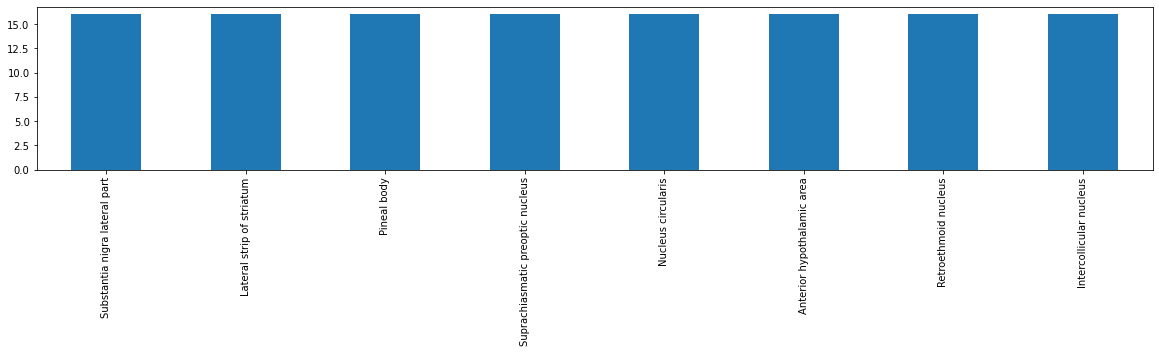

In [18]:
# make histogram of these
null_volume = [db_null_volume[subjects[0]].area.values]
for subject in subjects[1:]:
    null_volume.append(db_null_volume[subject].area.values)
null_volume = np.hstack(null_volume)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_volume).value_counts(sort=True).plot(kind='bar', axes=ax)

In [19]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_volume).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string())

                                  counts
Intercollicular nucleus               16
Retroethmoid nucleus                  16
Anterior hypothalamic area            16
Nucleus circularis                    16
Suprachiasmatic preoptic nucleus      16
Pineal body                           16
Lateral strip of striatum             16
Substantia nigra lateral part         16


# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [20]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['F10Control', 'F16Control', 'F11Control', 'F1Control'],
 'Unfam': ['F6Unfam', 'F8Unfam', 'F4Unfam', 'F2Unfam', 'F12Unfam', 'F14Unfam'],
 'Fam': ['F7Fam', 'F15Fam', 'F13Fam', 'F5Fam', 'F3Fam', 'F9Fam']}

# Calculate cell count across experimental groups

In [21]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [22]:
df_control_cell_count

,area,F10Control,F16Control,F11Control,F1Control
0,Frontal pole cerebral cortex,59,23,106,105
1,Primary motor area,1447,41,155,259
2,Secondary motor area,2448,219,587,1448
3,Primary somatosensory area,2755,444,377,1442
4,Supplemental somatosensory area,1055,122,403,493
...,...,...,...,...,...
194,Interfascicular nucleus raphe,1,0,0,0
195,Interpeduncular nucleus,3,0,0,0
196,Rostral linear nucleus raphe,0,0,0,0
197,Central linear nucleus raphe,1,0,0,0


In [23]:
df_fam_cell_count

,area,F7Fam,F15Fam,F13Fam,F5Fam,F3Fam,F9Fam
0,Frontal pole cerebral cortex,81,64,20,131,48,133
1,Primary motor area,189,304,413,178,387,471
2,Secondary motor area,1052,630,728,1198,405,1287
3,Primary somatosensory area,988,492,947,918,748,1548
4,Supplemental somatosensory area,434,774,649,404,391,433
...,...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,16,2,0,14,5,0
195,Interpeduncular nucleus,9,5,1,1,8,1
196,Rostral linear nucleus raphe,3,0,2,0,0,0
197,Central linear nucleus raphe,18,7,3,14,22,0


In [24]:
df_unfam_cell_count

,area,F6Unfam,F8Unfam,F4Unfam,F2Unfam,F12Unfam,F14Unfam
0,Frontal pole cerebral cortex,566,267,110,284,147,31
1,Primary motor area,4115,533,314,565,105,227
2,Secondary motor area,8207,1616,516,1696,633,343
3,Primary somatosensory area,7257,1974,609,1971,594,602
4,Supplemental somatosensory area,6662,595,335,409,303,289
...,...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,14,1,0,5,8,1
195,Interpeduncular nucleus,12,6,2,9,27,41
196,Rostral linear nucleus raphe,2,0,0,1,2,0
197,Central linear nucleus raphe,18,5,2,7,9,3


## Calculate t-tests across groups per area

In [25]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.829216,0.137702,0.0794234
1,Primary motor area,0.583415,0.563277,0.327241
2,Secondary motor area,0.51672,0.548981,0.323879
3,Primary somatosensory area,0.526337,0.529319,0.275283
4,Supplemental somatosensory area,0.98191,0.507623,0.402029
...,...,...,...,...
194,Interfascicular nucleus raphe,0.142165,0.1369,0.722495
195,Interpeduncular nucleus,0.123366,0.0775371,0.0842392
196,Rostral linear nucleus raphe,0.254139,0.13531,1
197,Central linear nucleus raphe,0.0473264,0.0445531,0.453769


In [26]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.829216,0.137702,0.0794234
1,Primary motor area,0.583415,0.563277,0.327241
2,Secondary motor area,0.51672,0.548981,0.323879
3,Primary somatosensory area,0.526337,0.529319,0.275283
4,Supplemental somatosensory area,0.98191,0.507623,0.402029
...,...,...,...,...
194,Interfascicular nucleus raphe,0.142165,0.1369,0.722495
195,Interpeduncular nucleus,0.123366,0.0775371,0.0842392
196,Rostral linear nucleus raphe,0.254139,0.13531,1
197,Central linear nucleus raphe,0.0473264,0.0445531,0.453769


In [27]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,6.17713e-05
Bed nuclei of the stria terminalis,0.001609
Ventral premammillary nucleus,0.00264979
Medial amygdalar nucleus,0.00310501
Cortical amygdalar area,0.00381713
Medial preoptic nucleus,0.00724906
Tuberal nucleus,0.0119723
Bed nucleus of the accessory olfactory tract,0.0133743
Accessory olfactory bulb,0.0196169


In [28]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000247517
Ventral premammillary nucleus,0.000490979
Cortical amygdalar area,0.00153788
Bed nuclei of the stria terminalis,0.00212997
Medial amygdalar nucleus,0.00213564
Periventricular hypothalamic nucleus posterior part,0.00271455
Nucleus of reuniens,0.00862385
Posterodorsal preoptic nucleus,0.012407
Tuberal nucleus,0.0132163


In [29]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Supramammillary nucleus,0.0111725
Nucleus of reuniens,0.0141052
Interanteromedial nucleus of the thalamus,0.0147649
Rhomboid nucleus,0.0224609
Preparasubthalamic nucleus,0.0408905
Central medial nucleus of the thalamus,0.0459932
Tuberomammillary nucleus,0.0484734
Intermediodorsal nucleus of the thalamus,0.0509426
Medial mammillary nucleus,0.0527203


## Mann Whitney Test for comparison across groups

In [30]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0463479
1,Primary motor area,0.227773,0.227773,0.235585
2,Secondary motor area,0.457553,0.37456,0.34446
3,Primary somatosensory area,0.457553,0.227773,0.34446
4,Supplemental somatosensory area,0.457553,0.457553,0.189239
...,...,...,...,...
194,Interfascicular nucleus raphe,0.0696649,0.0372996,0.467696
195,Interpeduncular nucleus,0.0315985,0.0117182,0.0262776
196,Rostral linear nucleus raphe,0.143434,0.0736161,0.464117
197,Central linear nucleus raphe,0.0238666,0.00653092,0.314575


In [31]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0463479
1,Primary motor area,0.227773,0.227773,0.235585
2,Secondary motor area,0.457553,0.37456,0.34446
3,Primary somatosensory area,0.457553,0.227773,0.34446
4,Supplemental somatosensory area,0.457553,0.457553,0.189239
...,...,...,...,...
194,Interfascicular nucleus raphe,0.0696649,0.0372996,0.467696
195,Interpeduncular nucleus,0.0315985,0.0117182,0.0262776
196,Rostral linear nucleus raphe,0.143434,0.0736161,0.464117
197,Central linear nucleus raphe,0.0238666,0.00653092,0.314575


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.00696096
Bed nucleus of the accessory olfactory tract,0.00696096
Tuberal nucleus,0.00710702
Posterior amygdalar nucleus,0.00710702
Cortical amygdalar area,0.00710702
Medial preoptic nucleus,0.00710702
Medial amygdalar nucleus,0.00710702
Bed nuclei of the stria terminalis,0.00710702
Periventricular hypothalamic nucleus posterior part,0.0123705


In [33]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Central linear nucleus raphe,0.00653092
Periventricular hypothalamic nucleus posterior part,0.00696096
Ventral premammillary nucleus,0.00696096
Nucleus of reuniens,0.00710702
Piriform-amygdalar area,0.00710702
Tuberal nucleus,0.00710702
Cortical amygdalar area,0.00710702
Medial amygdalar nucleus,0.00710702
Posterior amygdalar nucleus,0.00710702


In [34]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Supramammillary nucleus,0.00253743
Intermediodorsal nucleus of the thalamus,0.0122348
Preparasubthalamic nucleus,0.012807
Interanteromedial nucleus of the thalamus,0.01474
Nucleus of reuniens,0.0153195
Rhomboid nucleus,0.0219132
Tuberomammillary nucleus,0.0224756
Interpeduncular nucleus,0.0262776
Suprachiasmatic nucleus,0.0327761


## Calculate cross corr across groups per area on cell count

In [35]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_control_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Pretectal region,Cuneiform nucleus,Red nucleus,Oculomotor nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.119463,0.161993,-0.025738,0.163608,0.631976,0.588897,0.610254,0.570534,0.471496,...,0.355900,0.500350,-0.266102,-0.237284,-0.237284,0.008806,-0.237284,-0.237284,-0.237284,-0.237284
Primary motor area,-0.119463,1.000000,0.915245,0.939714,0.959388,0.393943,0.669511,0.408920,0.312560,0.652974,...,0.885097,0.099237,0.981692,0.990684,0.990684,0.968702,0.990684,0.990684,0.990684,0.990684
Secondary motor area,0.161993,0.915245,1.000000,0.981777,0.964243,0.729246,0.889500,0.741055,0.668393,0.901943,...,0.931151,0.483711,0.822732,0.854806,0.854806,0.984291,0.854806,0.854806,0.854806,0.854806
Primary somatosensory area,-0.025738,0.939714,0.981777,1.000000,0.936678,0.632840,0.791312,0.649173,0.587224,0.832801,...,0.865558,0.419574,0.870586,0.899103,0.899103,0.992065,0.899103,0.899103,0.899103,0.899103
Supplemental somatosensory area,0.163608,0.959388,0.964243,0.936678,1.000000,0.589483,0.841240,0.598618,0.494953,0.798291,...,0.978790,0.267327,0.896012,0.914784,0.914784,0.971445,0.914784,0.914784,0.914784,0.914784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pedunculopontine nucleus,0.008806,0.968702,0.984291,0.992065,0.971445,0.598928,0.800074,0.613515,0.535140,0.812704,...,0.911374,0.343102,0.906992,0.930778,0.930778,1.000000,0.930778,0.930778,0.930778,0.930778
Interfascicular nucleus raphe,-0.237284,0.990684,0.854806,0.899103,0.914784,0.268572,0.562306,0.285029,0.189265,0.547103,...,0.822465,-0.018600,0.998115,1.000000,1.000000,0.930778,1.000000,1.000000,1.000000,1.000000
Interpeduncular nucleus,-0.237284,0.990684,0.854806,0.899103,0.914784,0.268572,0.562306,0.285029,0.189265,0.547103,...,0.822465,-0.018600,0.998115,1.000000,1.000000,0.930778,1.000000,1.000000,1.000000,1.000000


In [36]:
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_fam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Oculomotor nucleus,Edinger-Westphal nucleus,Ventral tegmental nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Rostral linear nucleus raphe,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.248352,0.838450,0.555886,-0.508390,-0.402518,-0.047034,-0.671118,0.538818,-0.897261,...,-0.068300,-0.604234,0.577760,0.342612,0.480830,0.345025,-0.321418,-0.379792,-0.117430,0.430054
Primary motor area,-0.248352,1.000000,-0.228502,0.394937,0.145731,-0.052919,0.307654,0.563190,0.483570,0.146179,...,-0.180025,0.316242,0.595562,0.280865,0.594726,-0.908940,-0.316973,-0.279768,-0.556959,-0.851765
Secondary motor area,0.838450,-0.228502,1.000000,0.740562,-0.393241,-0.444366,0.459866,-0.655790,0.640759,-0.825277,...,0.177034,-0.183900,0.567327,0.235416,0.600657,0.339342,-0.465826,0.084321,-0.350534,0.401908
Primary somatosensory area,0.555886,0.394937,0.740562,1.000000,-0.514257,-0.574197,0.662506,-0.042868,0.889501,-0.618619,...,-0.017001,0.007087,0.852483,0.462521,0.884232,-0.112900,-0.425167,0.067703,-0.446585,-0.109806
Supplemental somatosensory area,-0.508390,0.145731,-0.393241,-0.514257,1.000000,0.763181,0.052683,-0.172367,-0.444399,0.351762,...,0.060177,0.392970,-0.250471,-0.229485,-0.151741,-0.517521,-0.157603,0.027645,-0.502131,-0.467187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interfascicular nucleus raphe,0.345025,-0.908940,0.339342,-0.112900,-0.517521,-0.219609,-0.186825,-0.364554,-0.272434,-0.245318,...,0.090774,-0.384980,-0.424839,-0.102407,-0.437173,1.000000,0.408070,0.363251,0.688860,0.874356
Interpeduncular nucleus,-0.321418,-0.316973,-0.465826,-0.425167,-0.157603,0.436953,-0.307423,0.276274,-0.719047,0.136103,...,-0.661095,-0.459053,-0.418113,0.375711,-0.444790,0.408070,1.000000,0.331195,0.763257,-0.010849
Rostral linear nucleus raphe,-0.379792,-0.279768,0.084321,0.067703,0.027645,0.112110,0.653723,0.108579,-0.241533,0.156936,...,0.097129,0.409855,-0.307148,-0.015654,-0.105875,0.363251,0.331195,1.000000,0.115169,0.096365


In [37]:
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)
corr_matrix_unfam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Edinger-Westphal nucleus,Trochlear nucleus,Ventral tegmental nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Rostral linear nucleus raphe,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.902023,0.939890,0.953106,0.877935,0.893917,0.887154,0.881074,0.881239,0.822717,...,0.269546,-0.152597,-0.527562,0.928035,0.549316,0.787803,-0.449177,0.581340,0.882335,0.909095
Primary motor area,0.902023,1.000000,0.994477,0.986813,0.996400,0.999076,0.990990,0.991142,0.975044,0.975503,...,-0.050521,-0.268765,-0.237246,0.851332,0.164974,0.804021,-0.210950,0.541844,0.887743,0.968428
Secondary motor area,0.939890,0.994477,1.000000,0.996765,0.987470,0.993022,0.984972,0.981355,0.966633,0.955183,...,0.013149,-0.273086,-0.296744,0.877812,0.261865,0.826789,-0.244046,0.575989,0.912532,0.977106
Primary somatosensory area,0.953106,0.986813,0.996765,1.000000,0.974260,0.983349,0.975146,0.965209,0.947304,0.932761,...,0.067504,-0.263345,-0.297090,0.889129,0.311567,0.799206,-0.269023,0.538385,0.895480,0.969162
Supplemental somatosensory area,0.877935,0.996400,0.987470,0.974260,1.000000,0.998825,0.994447,0.994311,0.975989,0.985866,...,-0.127522,-0.320213,-0.218376,0.813453,0.111570,0.821558,-0.162621,0.569370,0.897894,0.975084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interfascicular nucleus raphe,0.787803,0.804021,0.826789,0.799206,0.821558,0.816614,0.789232,0.814578,0.828015,0.784086,...,-0.038258,-0.333522,-0.346541,0.742815,0.324136,1.000000,0.017777,0.932179,0.978760,0.845187
Interpeduncular nucleus,-0.449177,-0.210950,-0.244046,-0.269023,-0.162621,-0.180396,-0.204434,-0.240429,-0.299091,-0.196688,...,-0.487705,-0.555326,0.817682,-0.461760,-0.404215,0.017777,1.000000,0.084311,-0.074686,-0.160952
Rostral linear nucleus raphe,0.581340,0.541844,0.575989,0.538385,0.569370,0.559128,0.528457,0.572683,0.609388,0.541503,...,-0.030124,-0.262613,-0.415227,0.551143,0.343113,0.932179,0.084311,1.000000,0.850564,0.614822


## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

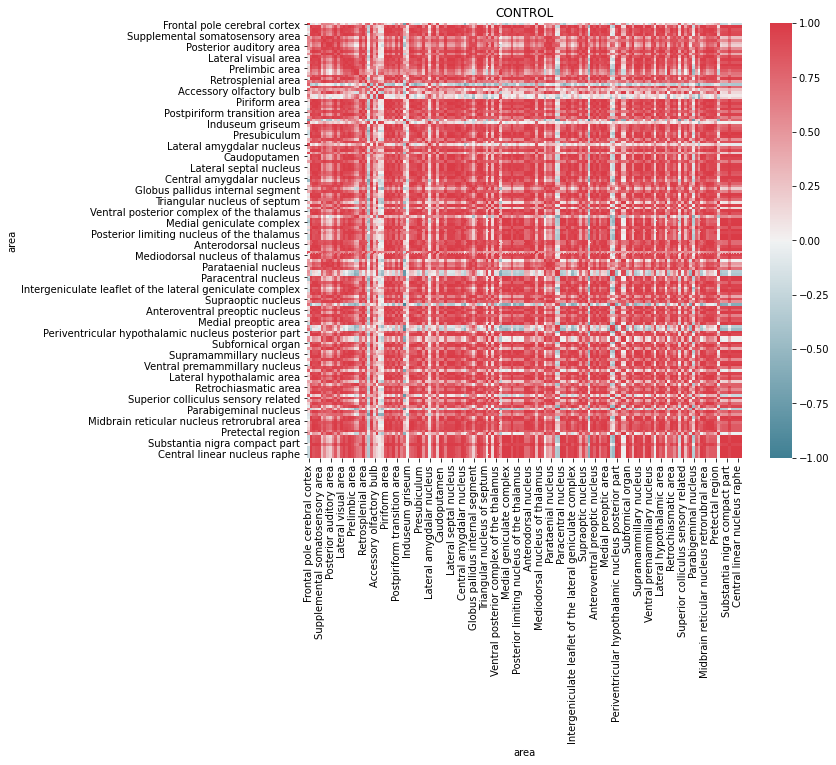

In [38]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

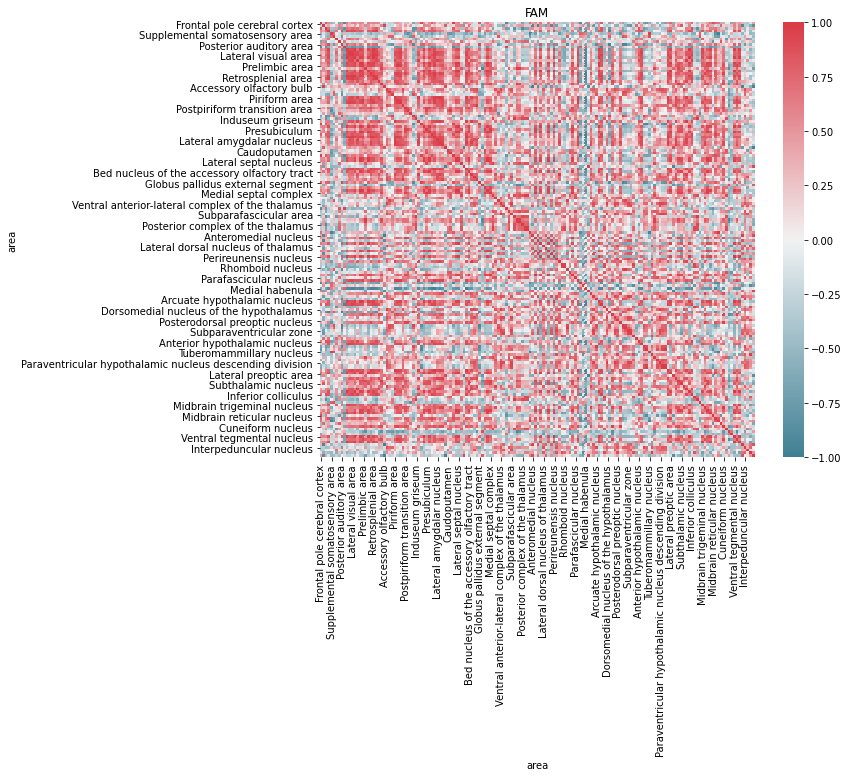

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

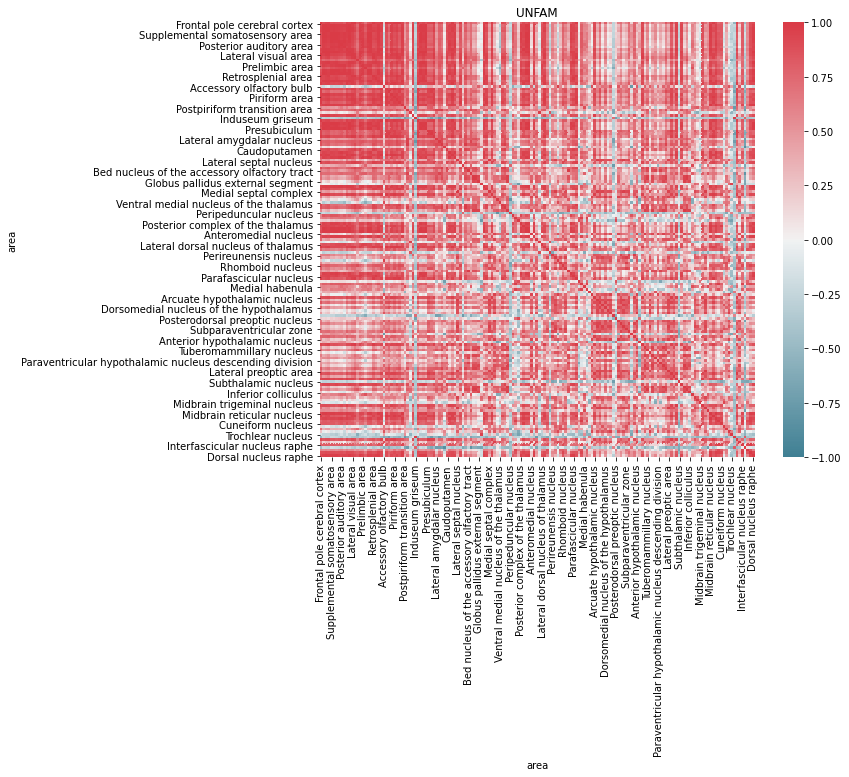

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [43]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [44]:
df_control_energy

,area,F10Control,F16Control,F11Control,F1Control
0,Frontal pole cerebral cortex,162101.616469,45852.503979,215700.991098,231505.087775
1,Primary motor area,364550.613676,8473.118078,32714.603757,56989.229935
2,Secondary motor area,514921.732492,38530.662549,105483.767790,269030.646286
3,Primary somatosensory area,334889.672220,53371.646658,38472.056519,167252.194756
4,Supplemental somatosensory area,324970.319497,34786.891993,107677.725014,135606.963231
...,...,...,...,...,...
194,Interfascicular nucleus raphe,12996.340091,0.000000,0.000000,0.000000
195,Interpeduncular nucleus,7452.801105,0.000000,0.000000,0.000000
196,Rostral linear nucleus raphe,0.000000,0.000000,0.000000,0.000000
197,Central linear nucleus raphe,9944.060127,0.000000,0.000000,0.000000


In [45]:
df_fam_energy

,area,F7Fam,F15Fam,F13Fam,F5Fam,F3Fam,F9Fam
0,Frontal pole cerebral cortex,202495.870411,145792.942019,43910.280011,268573.533459,101187.866423,334042.499512
1,Primary motor area,54638.029917,71690.394574,110299.469993,44672.405812,94238.953115,109713.396056
2,Secondary motor area,212137.335194,115916.836242,145483.056195,213175.989036,77292.596618,241137.956689
3,Primary somatosensory area,137141.781500,57956.380154,120009.400562,123727.854930,80661.820371,172376.753588
4,Supplemental somatosensory area,154571.389229,216075.852583,193026.015826,112436.594169,115353.222198,120744.695640
...,...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,175064.960235,26050.237047,0.000000,148842.052593,55657.488344,0.000000
195,Interpeduncular nucleus,30772.468570,14962.677270,2826.717388,2538.338144,20604.096244,2958.891209
196,Rostral linear nucleus raphe,44343.022034,0.000000,25937.134924,0.000000,0.000000,0.000000
197,Central linear nucleus raphe,213147.196796,166207.862128,35767.315543,176188.038696,235575.506745,0.000000


In [46]:
df_unfam_energy

,area,F6Unfam,F8Unfam,F4Unfam,F2Unfam,F12Unfam,F14Unfam
0,Frontal pole cerebral cortex,1.548755e+06,716936.937542,257979.402518,639418.173719,318999.274080,79963.563271
1,Primary motor area,9.805630e+05,148053.796718,67677.435268,124139.376198,24905.281976,67581.170010
2,Secondary motor area,1.697297e+06,364390.856541,92494.821600,301644.239041,115271.792053,75266.127309
3,Primary somatosensory area,7.869631e+05,277310.730919,61122.029473,223057.304181,62153.776599,98217.209227
4,Supplemental somatosensory area,2.130749e+06,216322.753494,85946.638549,113231.853630,84543.642519,107577.492886
...,...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,1.583965e+05,20904.653326,0.000000,58063.365296,92781.666195,15425.239789
195,Interpeduncular nucleus,3.979934e+04,20658.167352,5959.837724,26050.258438,101395.344019,278141.781518
196,Rostral linear nucleus raphe,3.186562e+04,0.000000,0.000000,23110.762747,37811.344867,0.000000
197,Central linear nucleus raphe,1.952696e+05,67742.404766,19418.606520,86571.109413,107783.499176,25293.547612


## T-test on energy across groups

In [47]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.77621,0.150396,0.0900627
1,Primary motor area,0.620508,0.563644,0.328591
2,Secondary motor area,0.494335,0.544893,0.312683
3,Primary somatosensory area,0.582874,0.515577,0.261163
4,Supplemental somatosensory area,0.981684,0.489713,0.38625
...,...,...,...,...
194,Interfascicular nucleus raphe,0.138007,0.113549,0.805519
195,Interpeduncular nucleus,0.124755,0.18295,0.14936
196,Rostral linear nucleus raphe,0.26283,0.122932,0.730359
197,Central linear nucleus raphe,0.0256288,0.0392912,0.281199


In [48]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.77621,0.150396,0.0900627
1,Primary motor area,0.620508,0.563644,0.328591
2,Secondary motor area,0.494335,0.544893,0.312683
3,Primary somatosensory area,0.582874,0.515577,0.261163
4,Supplemental somatosensory area,0.981684,0.489713,0.38625
...,...,...,...,...
194,Interfascicular nucleus raphe,0.138007,0.113549,0.805519
195,Interpeduncular nucleus,0.124755,0.18295,0.14936
196,Rostral linear nucleus raphe,0.26283,0.122932,0.730359
197,Central linear nucleus raphe,0.0256288,0.0392912,0.281199


In [49]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000567236
Bed nuclei of the stria terminalis,0.0031939
Cortical amygdalar area,0.00564351
Medial amygdalar nucleus,0.00584023
Medial preoptic nucleus,0.00775818
Ventral premammillary nucleus,0.00794633
Bed nucleus of the accessory olfactory tract,0.011894
Tuberal nucleus,0.0158849
Accessory olfactory bulb,0.0208514


In [50]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.00204643
Cortical amygdalar area,0.00329962
Periventricular hypothalamic nucleus posterior part,0.00533715
Nucleus of reuniens,0.00541071
Ventral premammillary nucleus,0.0072792
Bed nuclei of the stria terminalis,0.00731332
Medial amygdalar nucleus,0.00943985
Posterodorsal preoptic nucleus,0.0110938
Medial preoptic nucleus,0.0248236


In [51]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Nucleus of reuniens,0.00638682
Interanteromedial nucleus of the thalamus,0.0149844
Rhomboid nucleus,0.0156869
Supramammillary nucleus,0.0192732
Central medial nucleus of the thalamus,0.0410569
Suprachiasmatic nucleus,0.0479815
Medial mammillary nucleus,0.0482458
Intermediodorsal nucleus of the thalamus,0.0576893
Preparasubthalamic nucleus,0.0613524


## Calculate cross corr matrix across experimental groups on energy

## Mann-Whitney Test across groups

In [52]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0641026
1,Primary motor area,0.227773,0.168678,0.287587
2,Secondary motor area,0.457553,0.37456,0.405091
3,Primary somatosensory area,0.457553,0.227773,0.287587
4,Supplemental somatosensory area,0.297016,0.457553,0.235585
...,...,...,...,...
194,Interfascicular nucleus raphe,0.0696649,0.0238666,0.467868
195,Interpeduncular nucleus,0.033284,0.0117182,0.0226638
196,Rostral linear nucleus raphe,0.143434,0.0745506,0.394411
197,Central linear nucleus raphe,0.0238666,0.00653092,0.189239


In [53]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0641026
1,Primary motor area,0.227773,0.168678,0.287587
2,Secondary motor area,0.457553,0.37456,0.405091
3,Primary somatosensory area,0.457553,0.227773,0.287587
4,Supplemental somatosensory area,0.297016,0.457553,0.235585
...,...,...,...,...
194,Interfascicular nucleus raphe,0.0696649,0.0238666,0.467868
195,Interpeduncular nucleus,0.033284,0.0117182,0.0226638
196,Rostral linear nucleus raphe,0.143434,0.0745506,0.394411
197,Central linear nucleus raphe,0.0238666,0.00653092,0.189239


In [54]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Retroethmoid nucleus,0.00710702
Pineal body,0.00710702
Suprachiasmatic preoptic nucleus,0.00710702
Medial preoptic nucleus,0.00710702
Medial amygdalar nucleus,0.00710702
Cortical amygdalar area,0.00710702
Ventral premammillary nucleus,0.00710702
Posterior amygdalar nucleus,0.00710702
Tuberal nucleus,0.00710702


In [55]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Central linear nucleus raphe,0.00653092
Periventricular hypothalamic nucleus posterior part,0.00696096
Retroethmoid nucleus,0.00710702
Posterior amygdalar nucleus,0.00710702
Anterior hypothalamic area,0.00710702
Suprachiasmatic preoptic nucleus,0.00710702
Arcuate hypothalamic nucleus,0.00710702
Lateral strip of striatum,0.00710702
Nucleus circularis,0.00710702


In [56]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Retroethmoid nucleus,0.00710702
Intercollicular nucleus,0.00710702
Anterior hypothalamic area,0.00710702
Nucleus circularis,0.00710702
Suprachiasmatic preoptic nucleus,0.00710702
Lateral strip of striatum,0.00710702
Pineal body,0.00710702
Supramammillary nucleus,0.297016
Substantia nigra lateral part,0.00710702


In [57]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_control_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Pretectal region,Cuneiform nucleus,Red nucleus,Oculomotor nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.093576,0.341938,0.187184,0.324562,0.748230,0.687525,0.739128,0.687184,0.637008,...,0.523478,0.577790,-0.164043,-0.013393,-0.013393,0.205196,-0.013393,-0.013393,-0.013393,-0.013393
Primary motor area,0.093576,1.000000,0.935993,0.941357,0.971918,0.462758,0.760036,0.415823,0.339815,0.606559,...,0.893408,0.085641,0.964307,0.992949,0.992949,0.982525,0.992949,0.992949,0.992949,0.992949
Secondary motor area,0.341938,0.935993,1.000000,0.984609,0.973975,0.743206,0.917405,0.708520,0.648910,0.847587,...,0.929388,0.423876,0.820415,0.889649,0.889649,0.984377,0.889649,0.889649,0.889649,0.889649
Primary somatosensory area,0.187184,0.941357,0.984609,1.000000,0.944029,0.678067,0.840785,0.647331,0.601966,0.803337,...,0.858756,0.400517,0.859809,0.907496,0.907496,0.983726,0.907496,0.907496,0.907496,0.907496
Supplemental somatosensory area,0.324562,0.971918,0.973975,0.944029,1.000000,0.625417,0.887491,0.579460,0.496718,0.735927,...,0.970536,0.232073,0.876052,0.939092,0.939092,0.984254,0.939092,0.939092,0.939092,0.939092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pedunculopontine nucleus,0.205196,0.982525,0.984377,0.983726,0.984254,0.613800,0.846290,0.573507,0.507719,0.741925,...,0.916065,0.269399,0.908108,0.955867,0.955867,1.000000,0.955867,0.955867,0.955867,0.955867
Interfascicular nucleus raphe,-0.013393,0.992949,0.889649,0.907496,0.939092,0.356434,0.678399,0.308114,0.232552,0.512216,...,0.844122,-0.018053,0.988376,1.000000,1.000000,0.955867,1.000000,1.000000,1.000000,1.000000
Interpeduncular nucleus,-0.013393,0.992949,0.889649,0.907496,0.939092,0.356434,0.678399,0.308114,0.232552,0.512216,...,0.844122,-0.018053,0.988376,1.000000,1.000000,0.955867,1.000000,1.000000,1.000000,1.000000


In [58]:
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_fam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Oculomotor nucleus,Edinger-Westphal nucleus,Ventral tegmental nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Rostral linear nucleus raphe,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.270558,0.814449,0.641458,-0.555184,-0.325227,0.094862,-0.654374,0.565392,-0.951177,...,-0.390318,-0.607499,0.688903,0.677257,0.612226,0.261843,-0.213064,-0.265152,-0.209524,0.277539
Primary motor area,-0.270558,1.000000,-0.229368,0.169073,0.095685,-0.076741,0.254744,0.601679,0.324599,0.156015,...,0.146279,0.466886,0.502042,0.273892,0.543627,-0.882050,-0.358837,-0.149280,-0.682124,-0.794347
Secondary motor area,0.814449,-0.229368,1.000000,0.877903,-0.345204,-0.385774,0.576502,-0.548794,0.670596,-0.802906,...,0.028783,-0.140994,0.559350,0.503557,0.584729,0.334671,-0.260751,0.228966,-0.418531,0.355763
Primary somatosensory area,0.641458,0.169073,0.877903,1.000000,-0.476233,-0.586067,0.716299,-0.105158,0.817840,-0.624357,...,0.108873,0.065536,0.685481,0.575512,0.706086,0.106055,-0.291049,0.280450,-0.576741,0.124129
Supplemental somatosensory area,-0.555184,0.095685,-0.345204,-0.476233,1.000000,0.828206,0.156566,-0.090942,-0.554659,0.318570,...,0.195968,0.425957,-0.348373,-0.308935,-0.175820,-0.346597,0.078684,0.280417,-0.139216,-0.429920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interfascicular nucleus raphe,0.261843,-0.882050,0.334671,0.106055,-0.346597,-0.191898,0.014039,-0.284796,-0.177881,-0.111967,...,-0.130609,-0.396314,-0.433688,-0.152733,-0.482545,1.000000,0.502752,0.413918,0.678102,0.812670
Interpeduncular nucleus,-0.213064,-0.358837,-0.260751,-0.291049,0.078684,0.439725,0.048171,0.247278,-0.740331,0.155977,...,-0.607945,-0.440737,-0.395710,0.121775,-0.401439,0.502752,1.000000,0.503450,0.731168,-0.054860
Rostral linear nucleus raphe,-0.265152,-0.149280,0.228966,0.280450,0.280417,0.132638,0.776739,0.241420,-0.200914,0.174117,...,0.185354,0.345585,-0.301117,-0.055983,-0.162540,0.413918,0.503450,1.000000,0.075155,0.078132


In [59]:
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)
corr_matrix_unfam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Edinger-Westphal nucleus,Trochlear nucleus,Ventral tegmental nucleus,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Rostral linear nucleus raphe,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.927425,0.958009,0.972260,0.907351,0.917239,0.924388,0.919097,0.892717,0.867433,...,0.207239,-0.209199,-0.478778,0.839772,0.403940,0.784136,-0.482996,0.456935,0.882329,0.946914
Primary motor area,0.927425,1.000000,0.995085,0.976677,0.996823,0.998811,0.991465,0.993538,0.968380,0.980564,...,-0.067099,-0.293080,-0.223729,0.731521,0.077990,0.797708,-0.232522,0.408783,0.840399,0.963935
Secondary motor area,0.958009,0.995085,1.000000,0.988925,0.989104,0.992682,0.989120,0.987922,0.961327,0.965203,...,-0.009454,-0.299406,-0.285864,0.760569,0.163728,0.819395,-0.284676,0.444589,0.874352,0.978354
Primary somatosensory area,0.972260,0.976677,0.988925,1.000000,0.961557,0.968604,0.970873,0.955827,0.913236,0.921193,...,0.083764,-0.302212,-0.270992,0.784575,0.251841,0.770797,-0.292785,0.379906,0.848564,0.964905
Supplemental somatosensory area,0.907351,0.996823,0.989104,0.961557,1.000000,0.999377,0.992891,0.995044,0.973565,0.989764,...,-0.137721,-0.336085,-0.207963,0.686852,0.025414,0.816500,-0.198594,0.434364,0.847943,0.967523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interfascicular nucleus raphe,0.784136,0.797708,0.819395,0.770797,0.816500,0.815837,0.784276,0.817221,0.828529,0.789758,...,-0.052141,-0.364430,-0.345848,0.632395,0.264712,1.000000,-0.169983,0.867477,0.977510,0.853956
Interpeduncular nucleus,-0.482996,-0.232522,-0.284676,-0.292785,-0.198594,-0.211991,-0.238484,-0.283626,-0.344125,-0.223500,...,-0.474481,-0.469124,0.947042,-0.544350,-0.489442,-0.169983,1.000000,-0.175932,-0.300005,-0.272905
Rostral linear nucleus raphe,0.456935,0.408783,0.444589,0.379906,0.434364,0.434414,0.382297,0.452271,0.505712,0.415358,...,0.055855,-0.164292,-0.431087,0.450202,0.370718,0.867477,-0.175932,1.000000,0.799352,0.499178


## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

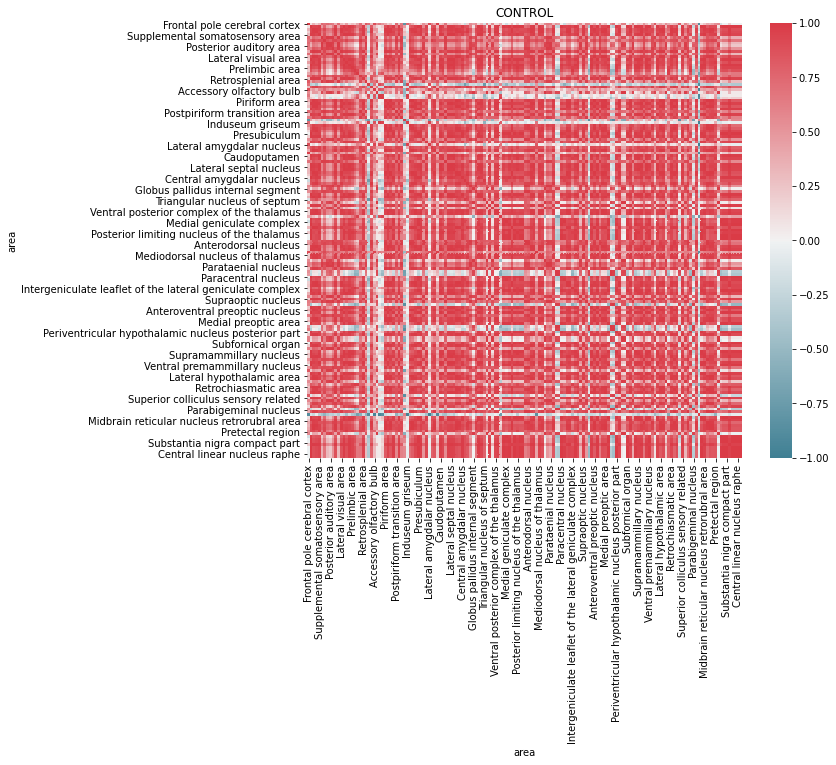

In [60]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

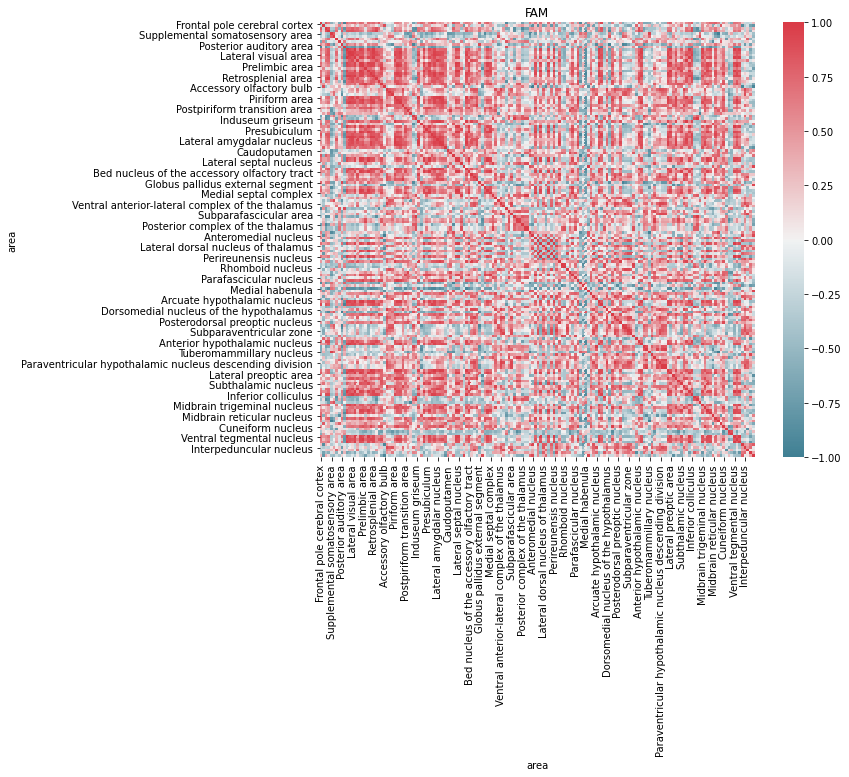

In [61]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

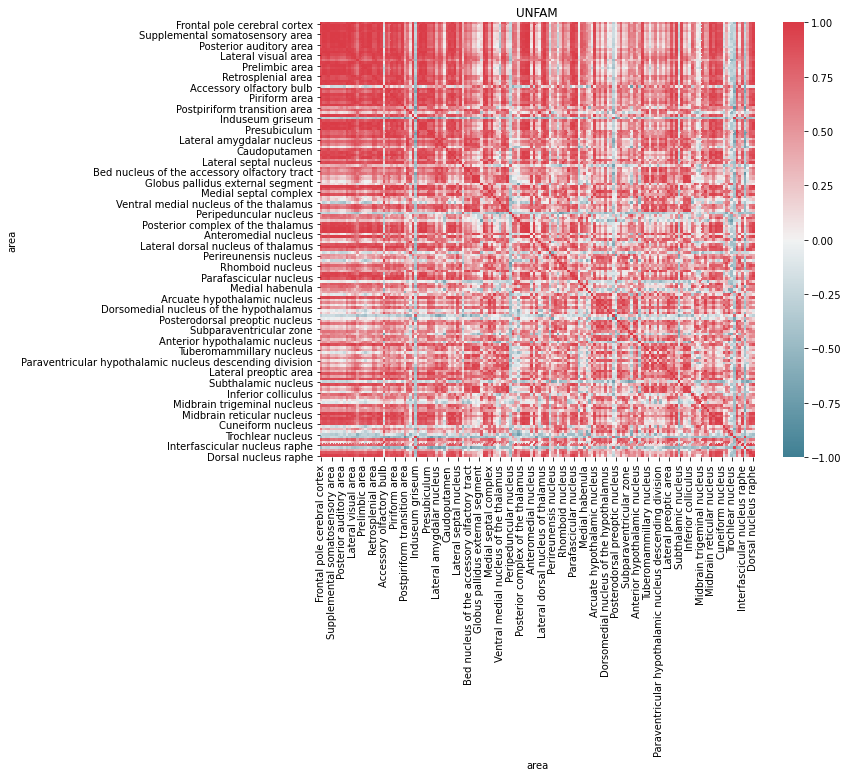

In [62]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')